# LAPD Crime Stats

<div style="text-align: right;">Jupyter Notebook on LAPD crime statistics<br> Author: David Scholtz (davidianscholtz@gmail.com)<br>For analysis and visualisation for Arno Venter<br>Commenced: 29 September 2023<br>Stage 1 Completed: 4 October 2023</div>

---

# Stage 1: Data Cleaning

**Stage 1 Goal**: Inspect data, conduct data quality checks, and prepare for visualisation in Tableau

1. Import packages in read in data sets
    * `LAPD_Calls_for_Service_2019.csv`
    * `LAPD_Calls_for_Service_2020.csv`
    * `LAPD_Calls_for_Service_2021.csv`
2. Get general data information and descriptive statistics
3. Check data quality
    * Correct values
    * Missing values
    * Currency of date values
    * Duplicates
    * Datetime values
4. Extract basic features useful for visualisation in Stage 2

---
  
## Imports and Read Data

In [1]:
# Import functional packages
import pandas as pd
import geopandas as gpd
import numpy as np
import datetime as dt
import geopandas as gpd

# Natural language processing
from collections import Counter
import re

# Visualisation
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

In [2]:
# Read in `LAPD_Calls_for_Service_2019.csv`
df_19 = pd.read_csv('data/LAPD_Calls_for_Service_2019.csv')

In [3]:
# Read in `LAPD_Calls_for_Service_2020.csv`
df_20 = pd.read_csv('data/LAPD_Calls_for_Service_2020.csv')

In [4]:
# Read in `LAPD_Calls_for_Service_2021.csv`
df_21 = pd.read_csv('data/LAPD_Calls_for_Service_2021.csv')

### Update Dataset

Data set of LAPD service calls was provided for 2019 to 2021. Updated data on service calls for 2022 up to 26/09/2023 were acced through the [Los Angeles Open Data](https://data.lacity.org/) site.

In [5]:
df_22 = pd.read_csv('add_data/LAPD_Calls_for_Service_2022.csv')

In [6]:
df_23 = pd.read_csv('add_data/LAPD_Calls_for_Service_2023_updated_20230926.csv')

### Concatenate Service Call Data for All Years

In [7]:
# Concatenate the three years' DataFrames
df0 = pd.concat([df_19, df_20, df_21, df_22, df_23], ignore_index=True)

# Reset the index of the concatenated DataFrame
df0.reset_index(drop=True, inplace=True)

In [13]:
mask = (df0['Area_Occ'] == 'Outside') & (df0['Call_Type_Text'] == 'AMB')
df0[mask].count()

Incident_Number    67
Area_Occ           67
Rpt_Dist            0
Dispatch_Date      67
Dispatch_Time      67
Call_Type_Code     67
Call_Type_Text     67
dtype: int64

In [14]:
mask = (df0['Area_Occ'] != 'Outside') & (df0['Call_Type_Text'] == 'AMB')
df0[mask].count()

Incident_Number    97413
Area_Occ           97413
Rpt_Dist           97413
Dispatch_Date      97413
Dispatch_Time      97413
Call_Type_Code     97413
Call_Type_Text     97413
dtype: int64

---
## Initial Inspection

In [8]:
# Inspect first five rows
df0.head()

,Incident_Number,Area_Occ,Rpt_Dist,Dispatch_Date,Dispatch_Time,Call_Type_Code,Call_Type_Text
0,LPD190704000047,N Hollywood,1532.0,07/04/2019 12:00:00 AM,00:14:49,507F,FIREWORKS
1,LPD190529006334,Outside,NaN,05/29/2019 12:00:00 AM,21:28:53,006,CODE 6
2,LPD190218001024,Southwest,379.0,02/18/2019 12:00:00 AM,07:46:54,507C,CONSTRUCTION
3,PD19120600001346,Northeast,1109.0,12/06/2019 12:00:00 AM,08:32:27,006,CODE 6
4,LPD190216004881,Van Nuys,933.0,02/16/2019 12:00:00 AM,21:14:49,507P,PARTY


In [9]:
# Check shape of DF
print(f'Number of columns: {df0.shape[1]}\nNumber of rows:    {df0.shape[0]}')

Number of columns: 7
Number of rows:    7750052


In [10]:
# Get row counts and data types
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7750052 entries, 0 to 7750051
Data columns (total 7 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Incident_Number  object 
 1   Area_Occ         object 
 2   Rpt_Dist         float64
 3   Dispatch_Date    object 
 4   Dispatch_Time    object 
 5   Call_Type_Code   object 
 6   Call_Type_Text   object 
dtypes: float64(1), object(6)
memory usage: 413.9+ MB


In [11]:
# No row counts given by .info()
# Get non-null value count for df0
df0.count()

Incident_Number    7750052
Area_Occ           7750052
Rpt_Dist           4752295
Dispatch_Date      7750052
Dispatch_Time      7750052
Call_Type_Code     7750052
Call_Type_Text     7750052
dtype: int64

In [12]:
# Check uniqueness of 'Incident_Number'
n_incident = df0['Incident_Number'].nunique()
print(f'Number of unique `Incident_Number` values: {n_incident}')

Number of unique `Incident_Number` values: 7750026


In [13]:
# Given that there is a difference of 26 between the number of rows and the unique values for 'Incident_Number', we should
# expect that there are 26 duplicate values for 'Incident_Number'
in_dup = df0['Incident_Number'].duplicated().sum()
print(f'Number of duplicate `Incident_Number` values: {in_dup}')

Number of duplicate `Incident_Number` values: 26


In [14]:
# Drop duplicates
df1 = df0.drop_duplicates('Incident_Number')

# Verify new df1 shape and unique values of `Incident_Number`
df1_rows = df1.shape[0]
incident_no_unique = df1['Incident_Number'].nunique()
print(f'df1 rows: {df1_rows}\nUnique "Incident_Number" values: {incident_no_unique}')

df1 rows: 7750026
Unique "Incident_Number" values: 7750026


In [15]:
# Check the values for 'Area_Occ'
n_unique = df1['Area_Occ'].nunique()
val_unique = df1['Area_Occ'].unique().tolist()
print(f'Number of unique values: {n_unique}\n\nUnique values:\n{val_unique}')

Number of unique values: 22

Unique values:
['N Hollywood', 'Outside', 'Southwest', 'Northeast', 'Van Nuys', 'Topanga', 'Mission', 'Southeast', 'Newton', 'Olympic', 'West Valley', 'Foothill', 'Wilshire', 'Pacific', 'Rampart', 'Harbor', 'Central', 'Hollywood', 'West LA', '77th Street', 'Devonshire', 'Hollenbeck']


In [16]:
# Check the number of unique `Rpt_Dist` codes
rpt_dist_unique = df1['Rpt_Dist'].nunique()
print(f'Number of Unique Reporting District codes: {rpt_dist_unique}')

Number of Unique Reporting District codes: 1150


In [17]:
# Calculate number and proportion of missing `Rpt_Dist` values
rpt_dist_missing = df1['Rpt_Dist'].isnull().sum()
total_rows = df1.shape[0]
rpt_dist_proportion_missing = rpt_dist_missing / total_rows

print(f'Total `Rpt_Dist` values missing:    {rpt_dist_missing}\nAs a proportion of the no. of rows: {round(rpt_dist_proportion_missing, 2)}') 

Total `Rpt_Dist` values missing:    2997750
As a proportion of the no. of rows: 0.39


### Summary

**DATAFRAME OBJECTS**

* **`df0`**: Concatenated DataFrames of 2019 to 26/09/2023 data on LAPD service calls
* **`df1`**: df0 with 26 duplicate `Incident_Number` values dropped

**INITIAL INSPECTION**

* The df1 DataFrame has a shape of 7 columns and 7750026 rows
* Each row has been dropped of duplicate `Incident_Number` values; each row now has a unique `Incident_Number` value
* 39% of rows have missing values for `Rpt_Dist`

**FURTHER ANALYSIS FOR CLEANING & QUALITY CHECK**

1. Interpret column names
2. Standardise column names
3. Set column data types
4. Check whether missing `Rpt_Dist` values correspond to another variable's values, e.g., to a specific `Area_Occ` value like 'Outside'
5. Check whether all `Call_Type_Code` values are paired with a single `Call_Type_Text` or whether a `Call_Type_Code` value is paired with multiple `Call_Type_Text` values

After quality checks have been made and dealt with, some feature engineering will be used to extract meaningful geographical information from the `Area_Occ` and `Rpt_Dist` variables. Date and time data will also be extracted from `Dispatch_Date` and `Dispatch_Time`. `Call_Type_Text` will be inspected and possibly a serious or violent crime variable will be extracted (murder, armed robbery, etc.).

* Geocode `Area_Occ` values
* Possibly geocode `Rpt_Dist` values
* Remove timestamp from `Dispatch_Date` and merge with `Dispatch_Time`
* Extract wet season feature from date

---

## Data Clean & Quality Check

* After retrieving service call records for 2022 up to 26/09/2023, the data should be up to date
* 26 duplicate `incident_number` values were dropped under **2. Initial Inspection**

**CLEANING & CHECKS**

1. Standardise column names
2. Set column data types
3. Verify date range from 01/01/2019 to 09/26/2023 without gaps
4. Verify no duplicate records
5. Check uniqueness of `Call_Type_Code` and `Call_Type_Text` pairs
6. See if there is a pattern to the null values in the `Rpt_Dist` column

### Column Names

**1. Interpret column names**

Column names have been interpreted based on their full names provided by the [Los Angeles Open Data](https://data.lacity.org/) site. The first data set on service calls uploaded on the site was in 2014. [The page for this data set](https://data.lacity.org/Public-Safety/LAPD-Calls-for-Service-2014/mgue-vbsx) has descriptions for the columns used in the subsequent updated data sets:

* `Incident_Number`: Unique event number assigned to Calls for Service by dispatch system.
* `Area_Occ`: A four-digit code that represents a sub-area within a Geographic Area. All calls for service records reference the "RD" that it occurred in for statistical comparisons.
* `Rpt_Dist`: Area where the occurrence is reported to have been.
* `Dispatch_Date`: MM/DD/YYYY
* `Dispatch_Time`: In 24 hour military time.
* `Call_Type_Code`: A code to indicate the type of call that was made.
* `Call_Type_Text`: Defines the Call Type Code provided.

**2. Standardise column names**

Retrieve the current column names and rename based on the above descriptions. New names will be given in snake_case.

In [18]:
# Standardise column names
# First get current column names
df1.columns

Index(['Incident_Number', 'Area_Occ', 'Rpt_Dist', 'Dispatch_Date',
       'Dispatch_Time', 'Call_Type_Code', 'Call_Type_Text'],
      dtype='object')

In [19]:
# Make lists of old and new column names
old_column_names = df1.columns.tolist()

new_column_names = ['incident_number', 'area', 'reporting_district', 'dispatch_date',
                    'dispatch_time', 'call_type_code', 'call_type_text']

# Create a dictionary from old and new names for renaming columns
new_columns_dict = {key: value for key, value in zip(old_column_names, new_column_names)}

# Rename columns
df2 = df1.rename(columns=new_columns_dict)

# Verify column names have been changed
df2.columns

Index(['incident_number', 'area', 'reporting_district', 'dispatch_date',
       'dispatch_time', 'call_type_code', 'call_type_text'],
      dtype='object')

### Set Data Types

In [20]:
# Inspect current data types
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7750026 entries, 0 to 7750051
Data columns (total 7 columns):
 #   Column              Dtype  
---  ------              -----  
 0   incident_number     object 
 1   area                object 
 2   reporting_district  float64
 3   dispatch_date       object 
 4   dispatch_time       object 
 5   call_type_code      object 
 6   call_type_text      object 
dtypes: float64(1), object(6)
memory usage: 473.0+ MB


In [21]:
# Remove decimal values from `reporting_districts`

# First, replace 'NaN' values with NaN floats
df2['reporting_district'] = df2['reporting_district'].replace('NaN', float('nan'))

# Then convert the column to a float data type
df2['reporting_district'] = df2['reporting_district'].astype('float')

# Remove decimal points by converting to integer
df2['reporting_district'] = df2['reporting_district'].astype(pd.Int64Dtype())

# Set `reporting_district` to object data type again
df2['reporting_district'] = df2['reporting_district'].astype('object')

# Inspect first few values
df2['reporting_district'].head(10)

0    1532
1    <NA>
2     379
3    1109
4     933
5     392
6    <NA>
7    2177
8    1981
9    1983
Name: reporting_district, dtype: object

In [22]:
# Create `dispatch_date_dt` column with a datetime data type from `dispatch_date`
df2['dispatch_date_dt'] = pd.to_datetime(df2['dispatch_date'], format='%m/%d/%Y %I:%M:%S %p')#.dt.date

# Create `dispatch_time_dt` column with a timedelta data type from `dispatch_time`
df2['dispatch_time_dt'] = pd.to_timedelta(df2['dispatch_time'])

# Combine new `dispatch_date_dt` and `dispatch_time_dt` columns to create a new datetime `dispatch_datetime` column
df2['dispatch_datetime'] = df2['dispatch_date_dt'] + df2['dispatch_time_dt']

# Verify new columns
df2.dtypes

incident_number                object
area                           object
reporting_district             object
dispatch_date                  object
dispatch_time                  object
call_type_code                 object
call_type_text                 object
dispatch_date_dt       datetime64[ns]
dispatch_time_dt      timedelta64[ns]
dispatch_datetime      datetime64[ns]
dtype: object

In [23]:
df2.head()

,incident_number,area,reporting_district,dispatch_date,dispatch_time,call_type_code,call_type_text,dispatch_date_dt,dispatch_time_dt,dispatch_datetime
0,LPD190704000047,N Hollywood,1532,07/04/2019 12:00:00 AM,00:14:49,507F,FIREWORKS,2019-07-04,0 days 00:14:49,2019-07-04 00:14:49
1,LPD190529006334,Outside,<NA>,05/29/2019 12:00:00 AM,21:28:53,006,CODE 6,2019-05-29,0 days 21:28:53,2019-05-29 21:28:53
2,LPD190218001024,Southwest,379,02/18/2019 12:00:00 AM,07:46:54,507C,CONSTRUCTION,2019-02-18,0 days 07:46:54,2019-02-18 07:46:54
3,PD19120600001346,Northeast,1109,12/06/2019 12:00:00 AM,08:32:27,006,CODE 6,2019-12-06,0 days 08:32:27,2019-12-06 08:32:27
4,LPD190216004881,Van Nuys,933,02/16/2019 12:00:00 AM,21:14:49,507P,PARTY,2019-02-16,0 days 21:14:49,2019-02-16 21:14:49


In [24]:
# Create a new instance of the df that drops the unneeded date and time columns
columns_to_drop = ['dispatch_date', 'dispatch_time', 'dispatch_date_dt', 'dispatch_time_dt']
df3 = df2.drop(columns=columns_to_drop, axis=1)

df3.head()

,incident_number,area,reporting_district,call_type_code,call_type_text,dispatch_datetime
0,LPD190704000047,N Hollywood,1532,507F,FIREWORKS,2019-07-04 00:14:49
1,LPD190529006334,Outside,<NA>,006,CODE 6,2019-05-29 21:28:53
2,LPD190218001024,Southwest,379,507C,CONSTRUCTION,2019-02-18 07:46:54
3,PD19120600001346,Northeast,1109,006,CODE 6,2019-12-06 08:32:27
4,LPD190216004881,Van Nuys,933,507P,PARTY,2019-02-16 21:14:49


### Verify Date Range

In [25]:
# Check min and max dates
min_date = df3['dispatch_datetime'].min()
max_date = df3['dispatch_datetime'].max()
print(f'Earliest date: {min_date}\nLatest date: {max_date}')

Earliest date: 2019-01-01 00:00:02
Latest date: 2023-09-26 00:14:14


In [26]:
# # Visualise time series weekwise
# Copy DataFrame for visualisation preparation
# df4 = df3.copy()

# # Aggregate data by week and year
# df4['year'] = df4['dispatch_datetime'].dt.year
# df4['week'] = df4['dispatch_datetime'].dt.strftime('%Y-%U')

# # Comment out the following groupby() function; the output is saved and read-in in the following cell
# weekly_calls = df4.groupby(['year', 'week'])['incident_number'].count().reset_index()

In [27]:
# # Save this table to a DataFrame so it can be read in rather than generated each time the kernel is run
# weekly_calls.to_csv('saved_data/weekly_calls.csv', index=False)

# Read in saved weekly_calls.csv
weekly_calls = pd.read_csv('saved_data/weekly_calls.csv')

In [28]:
weekly_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   year             251 non-null    int64 
 1   week             251 non-null    object
 2   incident_number  251 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 6.0+ KB


In [29]:
weekly_calls.head()

,year,week,incident_number
0,2019,2019-00,24270
1,2019,2019-01,35162
2,2019,2019-02,30898
3,2019,2019-03,38788
4,2019,2019-04,37512


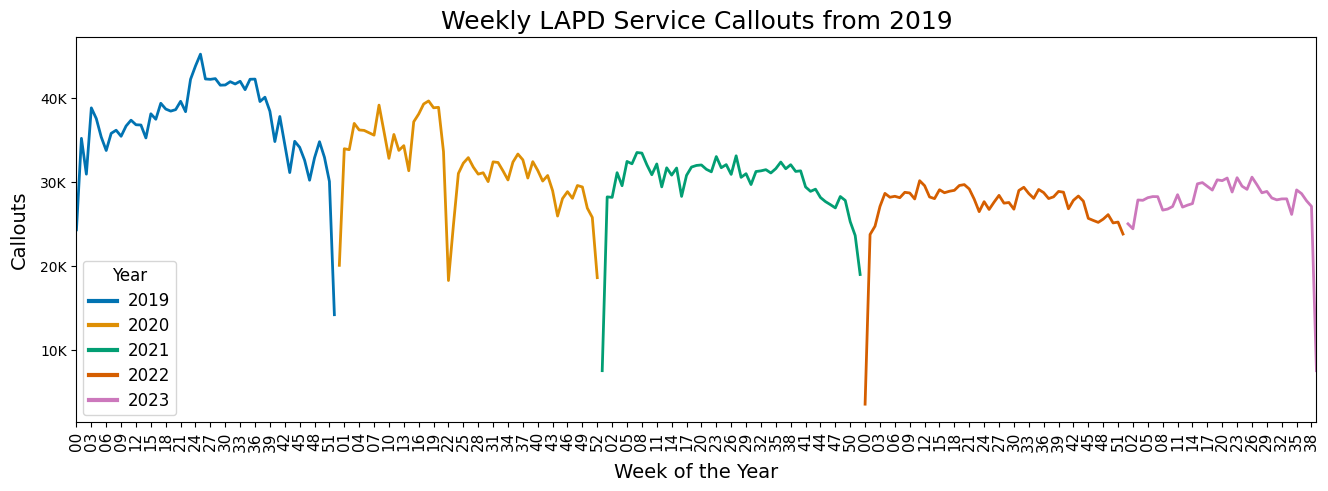

In [30]:
# Create a line plot using Seaborn with different colors for each year with a shaded area for the Covid lockdown
plt.figure(figsize=(16, 5))

sns.lineplot(data=weekly_calls, x='week', y='incident_number', hue='year', palette='colorblind', linewidth=2)
plt.title('Weekly LAPD Service Callouts from 2019', fontsize=18)
plt.xlabel('Week of the Year', fontsize=14)
plt.ylabel('Callouts', fontsize=14)
plt.xticks(rotation=90)  # Rotate x-axis labels

# Create a line plot
ax = plt.gca()

# Set x-axis limits
plt.xlim(weekly_calls['week'].min(), weekly_calls['week'].max())

# Set x-axis ticks to show every third week
labels = [item.get_text() for item in ax.get_xticklabels()]
ax.set_xticks(ax.get_xticks())  # Set the x-axis tick locations
ax.set_xticks(ax.get_xticks()[::3])  # Show every second x-axis tick
ax.set_xticklabels([label.split('-')[1] for label in labels[::3]], fontsize=11)  # Extract and display the week and set font size

# Set y-axis ticks to display values of thousands
def thousands(x, pos):
    return f'{x / 1000:.0f}K'

formatter = FuncFormatter(thousands)
ax.yaxis.set_major_formatter(formatter)
ax.yaxis.set_tick_params(labelsize=10)

# Add a legend for the colors (one color per year)
plt.legend(title='Year', loc='lower left')

legend = plt.legend(title='Year', loc='lower left')
for text in legend.get_texts():
    text.set_fontsize(12)  # Set legend text size
    
for line in legend.get_lines():
    line.set_linewidth(3)  # Set legend colour line size
    
legend.get_title().set_fontsize(12)

# Increase the distance between x and y-axis labels and values
ax.xaxis.labelpad = 8
ax.yaxis.labelpad = 8

plt.show()

The records appear to be consistent for the time period. There are predictable dips during the Christmas-New Year seasons. However, there is an unexpected dip in service calls around week 22 in 2020. This could be investigated further.

### Duplicate Records

Confirm that there are no duplicate records and no duplicate `incident_number` values.

In [31]:
# Check DataFrame duplicates
df_duplicates = df3.duplicated().sum()

# And check for `incident_number` duplicates
in_duplicates = df3['incident_number'].duplicated().sum()

print(f'Duplicate rows: {df_duplicates}\nDuplicate `incident_number` values: {in_duplicates}')

Duplicate rows: 0
Duplicate `incident_number` values: 0


### Call Types

Check uniqueness of `Call_Type_Code` and `Call_Type_Text` pairs

In [32]:
# Check for inconsistent mappings of 'call_type_code' and 'call_type_text'
inconsistent_pairings = df3.groupby('call_type_code')['call_type_text'].nunique().reset_index(name='unique_texts')

# Filter rows where there is more than one unique 'call_type_text' for the same 'call_type_code'
inconsistent_pairings = inconsistent_pairings[inconsistent_pairings['unique_texts'] > 1]

# Check how many 'call_type_text' values there typically are for one 'call_type_code'
inconsistent_pairings.describe()

,unique_texts
count,889.000000
mean,2.030371
std,0.171703
min,2.000000
25%,2.000000
50%,2.000000
75%,2.000000
max,3.000000


In [33]:
# Check for inconsistent mappings of 'call_type_code' and 'call_type_text'

# First, define a function to join each unique text paired with a call_type_code value
def concatenate_unique_texts(texts):
    return ', '.join(texts)

# Create a DataFrame with all unique code-text pairings, applying the above concatenate_unique_texts() function 
inconsistent_pairings_texts = df3.groupby('call_type_code')['call_type_text'].unique().reset_index(name='unique_texts')
inconsistent_pairings_texts['unique_texts'] = inconsistent_pairings_texts['unique_texts'].apply(concatenate_unique_texts)

# Count the unique 'call_type_text' values
inconsistent_pairings_texts['unique_texts_count'] = inconsistent_pairings_texts['unique_texts'].str.count(',') + 1

# Filter rows where there are more than one unique 'call_type_text' for the same 'call_type_code'
inconsistent_pairings_texts = inconsistent_pairings_texts[inconsistent_pairings_texts['unique_texts'].str.count(',') > 0]
        
# Inspect first few rows
inconsistent_pairings_texts.head(10)

,call_type_code,unique_texts,unique_texts_count
1,110,"NARCOTICS, 110 NARCOTICS",2
2,1101,"NARCOTIC ACTIVITY, 110 NARCOTIC ACTIVIT",2
5,110H,"CZN HOLDING SUSP, 110 CZN HOLDING SUSP",2
6,110O,"OFCR HOLDING SUSP, 110 OFCR HOLDING SUS",2
7,110P1,"POSS NARCOTIC ACT, 110 POSS NARCOTIC AC",2
8,110PS,"POSS NARCOTIC SUSP, 110 POSS NARCOTIC SU",2
9,110S,"NARCOTIC SUSP, 110 NARCOTIC SUSP",2
11,146,"IMPERS OFCR, 146 IMPERS OFCR",2
13,146I,"INVEST, 146 INVEST",2
15,146PS,"POSS SUSP, 146 POSS SUSP",2


In [34]:
# All of the first 10 values have identical unique texts except for the inclusion of the same or nearby numerical code

# Copy DataFrame (df4 was used in commented-out text earlier)
df5 = df3.copy()

# Drop all numerical characters and subsequent white space from the 'call_type_text' column and then reinspect code-text pairings
df5['call_type_text'] = df5['call_type_text'].str.replace(r'\d+\s*', '', regex=True)

# Now recheck which codes have more than one text pairing by running the same code in the previous two cells

# Check for inconsistent mappings of 'call_type_code' and 'call_type_text'
inconsistent_pairings1 = df5.groupby('call_type_code')['call_type_text'].nunique().reset_index(name='unique_texts')

# Filter rows where there is more than one unique 'call_type_text' for the same 'call_type_code'
inconsistent_pairings1 = inconsistent_pairings1[inconsistent_pairings1['unique_texts'] > 1]

# Check how many 'call_type_text' values there typically are for one 'call_type_code'
inconsistent_pairings1.describe()

,unique_texts
count,200.000000
mean,2.130000
std,0.337147
min,2.000000
25%,2.000000
50%,2.000000
75%,2.000000
max,3.000000


In [35]:
# Check for inconsistent mappings of 'call_type_code' and 'call_type_text'

# Create a DataFrame with all unique code-text pairings, applying the above concatenate_unique_texts() function 
inconsistent_pairings_texts1 = df5.groupby('call_type_code')['call_type_text'].unique().reset_index(name='unique_texts')
inconsistent_pairings_texts1['unique_texts'] = inconsistent_pairings_texts1['unique_texts'].apply(concatenate_unique_texts)

# Count the unique 'call_type_text' values
inconsistent_pairings_texts1['unique_texts_count'] = inconsistent_pairings_texts1['unique_texts'].str.count(',') + 1

# Filter rows where there are more than one unique 'call_type_text' for the same 'call_type_code'
inconsistent_pairings_texts1 = inconsistent_pairings_texts1[inconsistent_pairings_texts1['unique_texts'].str.count(',') > 0]
        
# Inspect first few rows
inconsistent_pairings_texts1.head(10)

,call_type_code,unique_texts,unique_texts_count
2,1101,"NARCOTIC ACTIVITY, NARCOTIC ACTIVIT",2
6,110O,"OFCR HOLDING SUSP, OFCR HOLDING SUS",2
7,110P1,"POSS NARCOTIC ACT, POSS NARCOTIC AC",2
8,110PS,"POSS NARCOTIC SUSP, POSS NARCOTIC SU",2
22,187A,"AMB , AMB",2
29,187P,"POSS , POSS",2
50,200,"UNUSUAL OCCURRENCE, UNUSUAL OCCURREN",2
55,207ADS,"AMB DOM VIOL SUSP, AMB DOM VIOL SUS",2
66,207DSL,"DOM VIOL SUSP J/L, DOM VIOL SUSP J/",2
67,207DSN,"DOM VIOL SUSP NOW, DOM VIOL SUSP NO",2


**FIXING CODE-TEXT PAIRINGS**

78% of the non-unique pairings have been fixed.

The first ten rows of the remaining non-unique pairings are due to minor character differences; one is either an incomplete version of the other or ends with a white space. I'll address each of these errors separately and re-inspect the non-unique pairings. First, I'll remove white space at the start and end of strings. Second, I'll split the two sets of strings and create a set of the the longer of the pair (where there are only two values). I will then replace the shorter strings with the longer strings.

In [36]:
# STEP 1

# Remove white spaces from the starts and ends of strings
df5['call_type_text'] = df5['call_type_text'].str.strip()

# Compile a new DataFrame of non-unique pairings as above
inconsistent_pairings_texts2 = df5.groupby('call_type_code')['call_type_text'].unique().reset_index(name='unique_texts')
inconsistent_pairings_texts2['unique_texts'] = inconsistent_pairings_texts2['unique_texts'].apply(concatenate_unique_texts)
inconsistent_pairings_texts2['unique_texts_count'] = inconsistent_pairings_texts2['unique_texts'].str.count(',') + 1
inconsistent_pairings_texts2 = inconsistent_pairings_texts2[inconsistent_pairings_texts2['unique_texts'].str.count(',') > 0]

# Check progress of fixing pairings
inconsistent_pairings_texts2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 197 entries, 2 to 1012
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   call_type_code      197 non-null    object
 1   unique_texts        197 non-null    object
 2   unique_texts_count  197 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 6.2+ KB


In [37]:
inconsistent_pairings_texts2.head()

,call_type_code,unique_texts,unique_texts_count
2,1101,"NARCOTIC ACTIVITY, NARCOTIC ACTIVIT",2
6,110O,"OFCR HOLDING SUSP, OFCR HOLDING SUS",2
7,110P1,"POSS NARCOTIC ACT, POSS NARCOTIC AC",2
8,110PS,"POSS NARCOTIC SUSP, POSS NARCOTIC SU",2
50,200,"UNUSUAL OCCURRENCE, UNUSUAL OCCURREN",2


In [38]:
# Group by 'call_type_code' and find the longest 'call_type_text' strings
longest_texts = df5.groupby('call_type_code')['call_type_text'].max().reset_index()

# Create a dictionary that maps 'call_type_code' with its corresponding longest 'call_type_text'
code_to_longest_text = dict(zip(longest_texts['call_type_code'], longest_texts['call_type_text']))

# Replace the 'call_type_text' column in the original DataFrame with the longest 'call_type_text' based on the mapping
df5['call_type_text'] = df5['call_type_code'].map(code_to_longest_text)

# Finally, compile a DataFrame of non-unique pairings to confirm pairings have been fixed
inconsistent_pairings_texts3 = df5.groupby('call_type_code')['call_type_text'].unique().reset_index(name='unique_texts')
inconsistent_pairings_texts3['unique_texts'] = inconsistent_pairings_texts3['unique_texts'].apply(concatenate_unique_texts)
inconsistent_pairings_texts3['unique_texts_count'] = inconsistent_pairings_texts3['unique_texts'].str.count(',') + 1
inconsistent_pairings_texts3 = inconsistent_pairings_texts3[inconsistent_pairings_texts3['unique_texts'].str.count(',') > 0]

# # Save csv files of df5 and inconsistent_pairings_texts3
# df5.to_csv('saved_data/df5.csv', index=False)
# inconsistent_pairings_texts3.to_csv('saved_data/inconsistent_pairings_texts3.csv', index=False)

# # Read in csv files
# df5 = pd.read_csv('saved_data/df5.csv')
# inconsistent_pairings_texts3 = pd.read_csv('saved_data/inconsistent_pairings_texts3.csv')

# If reading-in saved DataFrame from csv, ensure to change 'reporting_district' to integer then to object data type again

# Inspect non-unique pairings
inconsistent_pairings_texts3.describe()

,unique_texts_count
count,0.0
mean,NaN
std,NaN
min,NaN
25%,NaN
50%,NaN
75%,NaN
max,NaN


### `reporting_district` Null Values

Check if there is a pattern to null values in the `reporting_district` column. The most intuitive explanation for missing `reporting_district` values in a complete data set is that it is in a district beyond the reporting districts captured by the data. This also matches the first two occurrances of nulls values in the column at indices 1 and 6; these indices correspond to 'Outside' values in the `area` column.

In [39]:
# View first 10 rows of DataFrame
df5.head(7)

,incident_number,area,reporting_district,call_type_code,call_type_text,dispatch_datetime
0,LPD190704000047,N Hollywood,1532,507F,FIREWORKS,2019-07-04 00:14:49
1,LPD190529006334,Outside,<NA>,006,CODE,2019-05-29 21:28:53
2,LPD190218001024,Southwest,379,507C,CONSTRUCTION,2019-02-18 07:46:54
3,PD19120600001346,Northeast,1109,006,CODE,2019-12-06 08:32:27
4,LPD190216004881,Van Nuys,933,507P,PARTY,2019-02-16 21:14:49
5,PD19122100000089,Southwest,392,006,CODE,2019-12-21 00:21:03
6,LPD190719001920,Outside,<NA>,006,CODE,2019-07-19 09:56:22


In [40]:
# Count all unique values in 'area' column that have a corresponding null value in 'reporting_district' column

# Make and apply a Boolean mask to DataFrame for null values in 'reporting_district' column
mask = df5['reporting_district'].isna()
df5_masked = df5[mask]

# Get unique values from 'area' column
df5_masked['area'].unique()

array(['Outside'], dtype=object)

This confirms the intuition: The only value in `area` that corresponds to null values in `reporting_district` is 'Outside'.

### Summary

**DATAFRAME OBJECTS**

* **`df2`**: Changed column names to be more descriptive and in snake_case
* **`df3`**: Dropped `dispatch_date` and `dispatch_time` columns and synthesised into new `dispatch_datetime` column
* **`df4`**: Copy of df3 for `dispatch_datetime` timeseries visualisation
* **`weekly_calls`**: DataFrame with counts of `incicent_number` values by week for timeseries visualisation
* **`df5`**: Fixed `call_type_text` values where there were not unique code-text pairs

**CLEAN AND QUALITY CHECK**

* Columns have been renamed to be more descriptive and in snake_case
* Date data has been synthesised into new `dispatch_datetime` column with a datetime data type
* The data is up to date and has records throughout the data set's time period
* It was verified that there are no duplicate records
* Non-unique code-text pairings were addressed; `call_type_text` values were changed to ensure unique pairing
* Reporting districts that were in the 'Outside' `area`, i.e., in an area outside LA City, have null values

**NEXT STEPS**

The remaining preparation needed before visualisation and presentation is to engineer geographic data on `area` and `reporting_district` columns, create call type classes for groups of `call_type_text' values, and extract a season column.

---

## Feature Engineering

A feature has already been extracted in the `dispatch_datetime` column. Two additional kinds of features will be extracted: (i) geocoding of `area` and possibly `reporting_district`, and (ii) grouping `call_type_code`/`_text` into a smaller number of classes.

1. Add coordinates for areas
2. Get geo-data on reporting districts
3. Group call types into classes

### Geocode Areas

In [41]:
# Copy DataFrame before adding geographic columns
df6 = df5.copy()

# Get coordinates for LA areas
# (Most coordinates compiled by CGPT)
area_coordinates = {
    # 'Outside' refers to outside LA county; Oxnard coordinates are used
    'Outside': [34.196411, -119.170898],
    '77th Street': [34.0050, -118.2987],
    'Pacific': [33.9950, -118.4269],
    'Central': [34.0522, -118.2437],
    'Hollywood': [34.0928, -118.3287],
    'Southwest': [34.0050, -118.3315],
    'Newton': [34.0229, -118.2468],
    'Wilshire': [34.0674, -118.3723],
    'N Hollywood': [34.1870, -118.3813],
    'Olympic': [34.0522, -118.2437],
    'Southeast': [33.9497, -118.2523],
    'West LA': [34.0493, -118.4598],
    'Van Nuys': [34.1899, -118.4514],
    'Rampart': [34.0592, -118.2701],
    'Mission': [34.2700, -118.4619],
    'West Valley': [34.1867, -118.5277],
    'Northeast': [34.1088, -118.2201],
    'Topanga': [34.2101, -118.5904],
    'Harbor': [33.7557, -118.2725],
    'Hollenbeck': [34.0222, -118.2115],
    'Foothill': [34.3134, -118.2097],
    'Devonshire': [34.2500, -118.5274]
}

# Create a df with coordinates and areas as columns
df_area_coord = pd.DataFrame(list(area_coordinates.items()), columns=['area', 'coordinates'])

# Split the 'coordinates' column into 'latitude' and 'longitude'
df_area_coord[['area_latitude', 'area_longitude']] = pd.DataFrame(df_area_coord['coordinates'].tolist())

# Drop the original 'coordinates' column
df_area_coord.drop(columns=['coordinates'], inplace=True)

# Display the DataFrame head
df_area_coord.head()

,area,area_latitude,area_longitude
0,Outside,34.196411,-119.170898
1,77th Street,34.005000,-118.298700
2,Pacific,33.995000,-118.426900
3,Central,34.052200,-118.243700
4,Hollywood,34.092800,-118.328700


In [42]:
# Join coordinates to main DataFrame
df6 = df6.merge(df_area_coord, on='area', how='left')

df6.head()

,incident_number,area,reporting_district,call_type_code,call_type_text,dispatch_datetime,area_latitude,area_longitude
0,LPD190704000047,N Hollywood,1532,507F,FIREWORKS,2019-07-04 00:14:49,34.187000,-118.381300
1,LPD190529006334,Outside,<NA>,006,CODE,2019-05-29 21:28:53,34.196411,-119.170898
2,LPD190218001024,Southwest,379,507C,CONSTRUCTION,2019-02-18 07:46:54,34.005000,-118.331500
3,PD19120600001346,Northeast,1109,006,CODE,2019-12-06 08:32:27,34.108800,-118.220100
4,LPD190216004881,Van Nuys,933,507P,PARTY,2019-02-16 21:14:49,34.189900,-118.451400


### Reporting District Geo-data

A GeoJSON file from [geohub.lacity.org](https://geohub.lacity.org/datasets/lapd-reporting-district/explore?location=34.017836%2C-118.318142%2C10.73) (accessed 3 October 2023) provides geodata on LAPD reporting districts. This will be used to map the LA City area in Tableau, which can then be used to visualise the data. 

The GeoJSON file has been saved in `add_data/LAPD_Reporting_District.geojson`. The file will be inspected to ensure that there is a common column name to use as a key for joining and visualising in Tableau.

In [43]:
# Read in GeoJSON on LA City reporting districts
gdf_rd0 = gpd.read_file('add_data/LAPD_Reporting_District.geojson')

In [44]:
# Inspect head
gdf_rd0.head()

,FID,FID_1,AGENCY,BUREAU,APREC,ABBREV_APR,PREC,REPDIST,NAME,Shape__Area,Shape__Length,geometry
0,1,498,PD,WEST BUREAU,WILSHIRE,WILS,7,738,0738,1.202851e+06,4463.086085,"POLYGON ((-118.33160 34.06199, -118.33178 34.0..."
1,2,499,PD,WEST BUREAU,OLYMPIC,OLYM,20,2023,2023,4.782062e+05,2932.831534,"POLYGON ((-118.30035 34.06901, -118.30035 34.0..."
2,3,500,PD,WEST BUREAU,OLYMPIC,OLYM,20,2022,2022,5.087625e+05,3105.278467,"POLYGON ((-118.30911 34.06897, -118.30911 34.0..."
3,4,504,PD,CENTRAL BUREAU,RAMPART,RAMP,2,238,0238,6.190427e+05,3295.229361,"POLYGON ((-118.25662 34.06726, -118.25579 34.0..."
4,5,505,PD,CENTRAL BUREAU,CENTRAL,CENT,1,111,0111,1.456160e+06,5251.493537,"POLYGON ((-118.23586 34.06678, -118.23621 34.0..."


In [45]:
# Rename 'REPDIST' to match service call DataFrame's 'reporting_district'
gdf_rd1 = gdf_rd0.rename(columns={'REPDIST': 'reporting_district'})

# Inspect head
gdf_rd1.head()

,FID,FID_1,AGENCY,BUREAU,APREC,ABBREV_APR,PREC,reporting_district,NAME,Shape__Area,Shape__Length,geometry
0,1,498,PD,WEST BUREAU,WILSHIRE,WILS,7,738,0738,1.202851e+06,4463.086085,"POLYGON ((-118.33160 34.06199, -118.33178 34.0..."
1,2,499,PD,WEST BUREAU,OLYMPIC,OLYM,20,2023,2023,4.782062e+05,2932.831534,"POLYGON ((-118.30035 34.06901, -118.30035 34.0..."
2,3,500,PD,WEST BUREAU,OLYMPIC,OLYM,20,2022,2022,5.087625e+05,3105.278467,"POLYGON ((-118.30911 34.06897, -118.30911 34.0..."
3,4,504,PD,CENTRAL BUREAU,RAMPART,RAMP,2,238,0238,6.190427e+05,3295.229361,"POLYGON ((-118.25662 34.06726, -118.25579 34.0..."
4,5,505,PD,CENTRAL BUREAU,CENTRAL,CENT,1,111,0111,1.456160e+06,5251.493537,"POLYGON ((-118.23586 34.06678, -118.23621 34.0..."


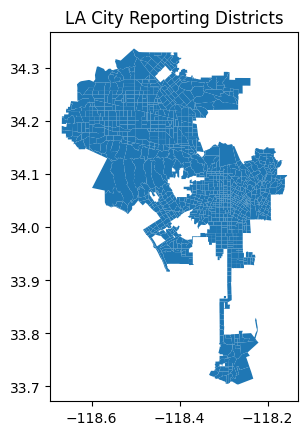

In [46]:
# Inspect the geodata area
gdf_rd1.plot()
plt.title('LA City Reporting Districts')
plt.show()

**REPORTING DISTRICTS PLOT EVALUATION**

This area looks correct; it matches the LA City shape area shown here.

<img src="LACity_ZeeMap-595069.png" alt="alt text" width="32%" height="auto" class="blog-image">

*Source: https://www.zeemaps.com/world-of-maps/map-of-la/*

**VERIFY DISTRICT CODES**

District codes in the GeoJSON and DataFrame will be checked for correlations. Most codes in the one should be present in the other.

In [47]:
df6['reporting_district'].head()

0    1532
1    <NA>
2     379
3    1109
4     933
Name: reporting_district, dtype: object

In [48]:
# Ensure GeoJSON has same reporting district codes as DataFrame

# Assign district codes to variables dropping any null values
rd_gdf_no_null = gdf_rd1['reporting_district'].dropna()
rd_df_no_null = df6['reporting_district'].dropna()

# Transform into sets of codes to get unique values
rd_codes_gdf_set = set(rd_gdf_no_null)
rd_codes_df_set = set(rd_df_no_null)

# Transform to lists
rd_codes_gdf_list = list(rd_codes_gdf_set)
rd_codes_df_list = list(rd_codes_df_set)

# Initialise a count of district codes in gdf that are not in df
rd_codes_not_in_df = 0

# Count codes missing from df
for code in rd_codes_gdf_list:
    if code not in rd_codes_df_list:
        rd_codes_not_in_df += 1

# Initialise a count of district codes in df that are not in gdf
rd_codes_not_in_gdf = 0

# Count codes missing from gdf
for code in rd_codes_df_list:
    if code not in rd_codes_gdf_list:
        rd_codes_not_in_gdf += 1

# Display number of unique codes missing from each object
print(f'GeoJSON codes not in DataFrame: {rd_codes_not_in_df}\nDataFrame codes not in GeoJSON: {rd_codes_not_in_gdf}')

GeoJSON codes not in DataFrame: 0
DataFrame codes not in GeoJSON: 15


15 out of 1150 unique reporting district codes in the DataFrame are missing from the GeoJSON. This works out to about 1.3% of the unique district codes and, so, is an acceptable missing proportion.

**EXPORT GeoJSON**

The GeoJSON with renamed column will now be exported as `saved_data/lapd_reporting_district.geojson`.

In [49]:
# Save the GeoDataFrame as a GeoJSON file
gdf_rd1.to_file('saved_data/lapd_reporting_district.geojson', driver="GeoJSON")

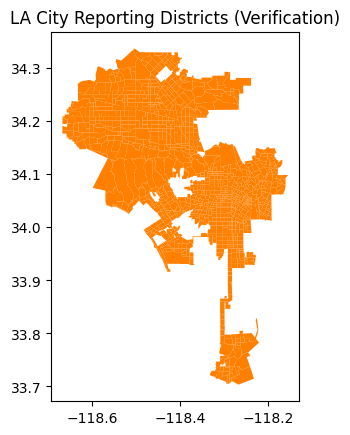

In [50]:
# Read in saved GeoJSON and verify with plot
gdf_rd_verify = gpd.read_file('lapd_reporting_district.geojson')

# Plot for verification
gdf_rd_verify.plot(color='#FF8000')
plt.title('LA City Reporting Districts (Verification)')
plt.show()

### Call Codes Classification

* Use NLP to retrieve the most commonly occurring words in `call_type_text`
* Extract features based on commonly occurring words, either as `call_type_text` values that contain a word substring or one of several related substrings

In [51]:
# Copy DataFrame
df7 = df6.copy()

# Get the number of unique 'call_type_text' values and the inspect the first 10 values
unique_call_types = df7['call_type_text'].nunique()
print(f'Number of unique call types: {unique_call_types}\n')

print(df7['call_type_text'].head(10))

Number of unique call types: 643

0               FIREWORKS
1                    CODE
2            CONSTRUCTION
3                    CODE
4                   PARTY
5                    CODE
6                    CODE
7           POSS SUSP NOW
8    AMB PEDESTRIAN INVOL
9                    CODE
Name: call_type_text, dtype: object


In [52]:
# Inspect top 20 most frequent values for 'call_type_text'
df7['call_type_text'].value_counts().head(20)

call_type_text
CODE               3326910
TRAFFIC STOP        440927
MAN                 324227
SUSP NOW            202356
CODE RINGER         198524
GRP                 160453
TRESPASS SUSP       159490
SUSP                141612
AMB                 127838
DOM VIOL            126797
INVEST              126141
PARTY               116634
RADIO               100682
POSS SUSP            94579
WOMAN                84580
UNKNOWN TROUBLE      69712
MAN/WMN              66348
FAMILY               65907
J/O                  64766
SUSP J/L             60040
Name: count, dtype: int64

In [53]:
# Run NLP to tokenise the text, count word frequencies, and select the most common words

# Combine all text and convert to uppercase
text = ' '.join(df7['call_type_text']).upper() 

# Tokenisation using regular expression
words = re.findall(r'\w+', text)  
word_counts = Counter(words)
most_common_words100 = word_counts.most_common(100)  # Show 100 most common words

# Display 100 most common words
print("Most Common Words:")
rank_no = 0
for word, count in most_common_words100:
    rank_no += 1
    print(f"({rank_no}) - {word}: {count}")

Most Common Words:
(1) - CODE: 3525434
(2) - SUSP: 874552
(3) - MAN: 465053
(4) - TRAFFIC: 443717
(5) - STOP: 440927
(6) - NOW: 329402
(7) - AMB: 307887
(8) - POSS: 275467
(9) - O: 231985
(10) - TRESPASS: 213139
(11) - J: 206976
(12) - RINGER: 203066
(13) - INVEST: 197959
(14) - DOM: 188735
(15) - VIOL: 188735
(16) - GRP: 170968
(17) - WMN: 140497
(18) - PARTY: 116634
(19) - R: 109008
(20) - RADIO: 100682
(21) - WOMAN: 85834
(22) - L: 81633
(23) - ATT: 81055
(24) - FAMILY: 78639
(25) - UNKNOWN: 72081
(26) - TROUBLE: 72081
(27) - NEIGHBOR: 63401
(28) - D: 62943
(29) - SUICIDE: 54856
(30) - MALE: 54171
(31) - H: 51694
(32) - OTHER: 50716
(33) - BFV: 50597
(34) - W: 46436
(35) - BUSN: 39654
(36) - SHOTS: 38672
(37) - MISD: 38628
(38) - FIRED: 38546
(39) - SILENT: 38439
(40) - COMPLAINT: 38032
(41) - FIGHT: 37128
(42) - GTA: 36888
(43) - VEH: 36406
(44) - LANDLORD: 34395
(45) - TENANT: 34395
(46) - FEM: 33604
(47) - HEARD: 32813
(48) - ONLY: 32813
(49) - P: 30832
(50) - I: 30098
(51) - NAR

In [54]:
# Create binary columns indicating call type class

# Write a function for creating a column if corresponding 'call_type_text' contains a substring
def column_call_class(new_column_name, substring_list):
    # Inform user if substring_list kwarg is not a list type
    if not isinstance(substring_list, list):
        print('Warning: "substring_list" kwarg must be list dtype. Function terminated.')
    else:
        # Inform user if a column with column_name already exists and give option to continue function
        if new_column_name in df7.columns:
            print('Error: Column with column_name already exists. Use different value for kwarg new_column_name.')
        # Create binary column with 1 value if 'call_type_text' contains any substring in substring_list, otherwise 0
        df7[new_column_name] = df7['call_type_text'].apply(lambda x: 1 if any(substring in x for substring in substring_list) else 0)

In [55]:
# Call call_type_class_column function to create new binary columns for call classes

# Create a 'theft' column
theft_substrings = ['ROBBE', 'THEFT', 'GTA', 'GRAND TH', 'J/L', 'SHOPLI']
column_call_class(new_column_name='theft', substring_list=theft_substrings)

# Create 'violent_or_threat' column
violent_or_threat_substrings = ['BATTER', 'KNI', 'GUN', 'SHOT', 'ASSLTG', 'VIOL', 'BOMB',
                                'ARSON', 'ATTACK', 'ABUSE', 'R/A']
column_call_class(new_column_name='violent_or_threat', substring_list=violent_or_threat_substrings)

# Create 'child_related' column
child_related_substrings = ['CPI', 'CHILD']
column_call_class(new_column_name='child_related', substring_list=child_related_substrings)

# Create column 'hate_related' column
hate_related_substrings = ['HATE']
column_call_class(new_column_name='hate_related', substring_list=hate_related_substrings)

# Create column 'drug_alcohol'
drug_alcohol_substrings = ['NARC', 'O/D', 'INTOX', 'DUI']
column_call_class(new_column_name='drug_alcohol', substring_list=drug_alcohol_substrings)

# Create column 'suicide_related'
suicide_related_substrings = ['SUIC']
column_call_class(new_column_name='suicide_related', substring_list=suicide_related_substrings)

# Create column 'juvenile_related'
juvenile_related_substrings = ['JUV', 'J/']
column_call_class(new_column_name='juvenile_related', substring_list=juvenile_related_substrings)

In [56]:
# Inspect head of new columns
df7.head()

,incident_number,area,reporting_district,call_type_code,call_type_text,dispatch_datetime,area_latitude,area_longitude,theft,violent_or_threat,child_related,hate_related,drug_alcohol,suicide_related,juvenile_related
0,LPD190704000047,N Hollywood,1532,507F,FIREWORKS,2019-07-04 00:14:49,34.187000,-118.381300,0,0,0,0,0,0,0
1,LPD190529006334,Outside,<NA>,006,CODE,2019-05-29 21:28:53,34.196411,-119.170898,0,0,0,0,0,0,0
2,LPD190218001024,Southwest,379,507C,CONSTRUCTION,2019-02-18 07:46:54,34.005000,-118.331500,0,0,0,0,0,0,0
3,PD19120600001346,Northeast,1109,006,CODE,2019-12-06 08:32:27,34.108800,-118.220100,0,0,0,0,0,0,0
4,LPD190216004881,Van Nuys,933,507P,PARTY,2019-02-16 21:14:49,34.189900,-118.451400,0,0,0,0,0,0,0


In [57]:
# Get counts for each new class of calls
theft_count = df7['theft'].sum()
violent_count = df7['violent_or_threat'].sum()
child_count = df7['child_related'].sum()
hate_count = df7['hate_related'].sum()
drug_count = df7['drug_alcohol'].sum()
suicide_count = df7['suicide_related'].sum()
juvenile_count = df7['juvenile_related'].sum()

print(f'Theft: {theft_count}\nViolent: {violent_count}\nChild: {child_count}\nHate: {hate_count}\
      \nDrug: {drug_count}\nSuicide: {suicide_count}\nJuvenile: {juvenile_count}')

Theft: 145709
Violent: 347274
Child: 44772
Hate: 1274      
Drug: 104721
Suicide: 54856
Juvenile: 222694


### Wet Season

According to [seasonyear.com](https://seasonsyear.com/USA/California/Los-Angeles#:~:text=The%20city%20lies%20within%20zone,dry%20(April%2DOctober).), the LA wet season runs from November to March and the dry season from April to October. Since this may affect types of service calls or the time of day certain calls are made, this may be meaningful information to represent. 

A binary `wet_season` column will indicate whether the time of year is wet or dry, making it easier to filter the seasons in visualisation.

In [58]:
# Copy DataFrame
df8 = df7.copy()

In [59]:
# Add a `wet_season` column with 1 for wet (November to March)

# First construct a list with binary values for month's season
wet_season = []
for date in df8['dispatch_datetime']:
    dt_month = date.month
    if (11 <= dt_month) or (dt_month <= 3):
        is_wet = 1
    else:
        is_wet = 0
    wet_season.append(is_wet)


In [60]:
# Count the number of months in the wet and dry seasons
wet = 0
dry = 0
for season in wet_season:
    if season == 1:
        wet += 1
    else:
        dry += 1
print(f'Wet months: {wet}\nDry months: {dry}')

Wet months: 3001576
Dry months: 4748450


In [61]:
# Join the wet_season list to df
df8['wet_season'] = wet_season

# Inspect DataFrame head
df8.head()

,incident_number,area,reporting_district,call_type_code,call_type_text,dispatch_datetime,area_latitude,area_longitude,theft,violent_or_threat,child_related,hate_related,drug_alcohol,suicide_related,juvenile_related,wet_season
0,LPD190704000047,N Hollywood,1532,507F,FIREWORKS,2019-07-04 00:14:49,34.187000,-118.381300,0,0,0,0,0,0,0,0
1,LPD190529006334,Outside,<NA>,006,CODE,2019-05-29 21:28:53,34.196411,-119.170898,0,0,0,0,0,0,0,0
2,LPD190218001024,Southwest,379,507C,CONSTRUCTION,2019-02-18 07:46:54,34.005000,-118.331500,0,0,0,0,0,0,0,1
3,PD19120600001346,Northeast,1109,006,CODE,2019-12-06 08:32:27,34.108800,-118.220100,0,0,0,0,0,0,0,1
4,LPD190216004881,Van Nuys,933,507P,PARTY,2019-02-16 21:14:49,34.189900,-118.451400,0,0,0,0,0,0,0,1


### Export DataFrame

In [62]:
# Check final row and column count
df8.shape

(7750026, 16)

In [63]:
# Export df8 to CSV file for visualisation
df8.to_csv('saved_data/lapd_servicecalls_2019to2023_final.csv', index=False)

### Summary

**DATAFRAME OBJECTS**

* **`df6`**: Added latitude and longitude columns for areas
* **`gdf_rd0`**: GeoJSON of reporting district geo data
* **`gdf_rd1`**: GeoJSON of reporting districts with column renamed to `reporting_district` to match DataFrame, exported as `saved_data/lapd_reporting_district.geojson`
* **`gdf_rd1`**: GeoJSON read-in of `saved_data/lapd_reporting_district.geojson` to verify geo data
* **`df7`**: Seven columns added for extracted call type classes: theft, violent, child, hate, drug, suicide, and juvenile
* **`df8`**: Column `wet_season` added indicating whether the `dispatch_datetime` falls within LA's wet (1) or dry (0) season

**FEATURE ENGINEERING**

* Coordinates for LA City areas were compiled and added as columns to the DataFrame
* A GeoJSON file for LA City reporting districts accessed through <https://geohub.lacity.org>; the district code column was renamed to match the DataFrame's `reporting_district` and exported for visualisation
* 15 of the 1150 unique reporting district codes in the DataFrame are missing from the GeoJSON file; this could be investigated further but is not necessary for this project at present
* Seven call classes were created from eyeballing results of some simple NLP analysis

**FURTHER ANALYSIS**

Should there be other call classes of interest, additional classes may be created around, for example, women, trespassing, traffic stops/violations, gun-related, etc.

---

## Conclusion

This notebook read in and concatenated LAPD data on service calls from 2019 to 26/09/2023. The final DataFrame, `df8`, has 7750026 rows and 16 columns. The The data was inspected and issues of quality were dealt with. The following is a summary of the **data cleaning**:

* The original column names were changed to be more descriptive and put in snake_case
* 26 duplicate `incident_number` values detected and dropped; no other duplication issues detected
* The reporting district column (`reporting_district`) was the only column with missing values:
    * 39% of rows have missing values
    * Missing values correlated with 'Outside' value in `area` column
* `reporting_district` values were cleaned
* The code-text pairs of `call_type_code` and `call_type_text` were adjusted to have unique pairings

**FEATURE ENGINEERING**

Several columns were added to the DataFrame:

* Dispatch date and time columns were joined to create a single datetime column: `dispatch_datetime`
* Select call types were grouped to create seven classes, which were each added with their own binary column
* A binary column was extracted to indicate whether a service call occurred during LA's wet (November to March) or dry (April to October) season

**OUTPUTS**

1. **`lapd_reporting_district.geojson`**: GeoJSON file with data on LA reporting district mappings; has common `reporting_district` column with DataFrame `df8`

2. **`lapd_servicecalls_2019to2023_final.csv`**: CSV file of final Pandas DataFrame `df8` with a shape of (7750026, 16)

---